#Grafos

En este proyecto debe escribir una función `camino(Grafo, nodo1,nodo2)` que construya el camino más económico usando el algoritmo codicioso de Dijkstra a dos pasos.

Considere por ejemplo el siguiente grafo:

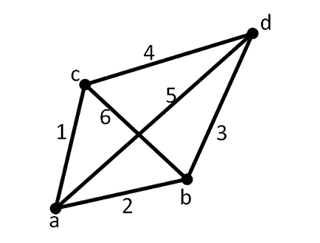

Supongamos que queremos calcular el camino más económico desde a hasta d. En este caso hay cinco caminos posibles con costos:
+ a-b-d. Costo =5
+ a-c-d. Costo =5
+ a-b-c-d. Costo = 12
+ a-c-b-d. Costo = 10
+ a-d. Costo = 5

Note que el primer nodo está fijo: a, pero el segundo nodo tiene 3 posibilidades, el tercero dos y así sucesivamente. Es decir que en un grafo completo de $n$ nodos hay $(n-1)!$ caminos posibles.

Su función `caminos(nodo1, nodo2)` va a calcular todas las parejas de nodos y va a tomar la más económica. Por ejemplo:

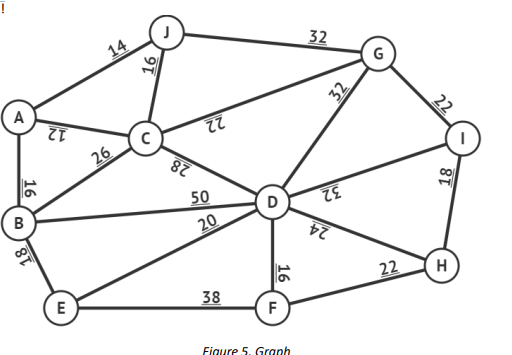

Si queremos calcular `camino(G, "A", "H")` su función debe considerar todas las parejas:
+ A-J-G
+ A-J-C
+ A-C-J
+ A-C-G
+ A-B-E
+ A-B-C
+ A-B-D
y esoger la pareja más económica. Luego seguir así hasta llegar al nodo deseado "H".

Sun función `camino("A", "H")` debe retornar el costo y el camino más económico usando este algoritmo.

**Bono:** Haga una animación de la busqueda de caminos.

**Más Bonos:** Compare su respuesta con el camino más económico.

In [1]:
#@title Clase de grafos.
# Copyright 2013, Michael H. Goldwasser
#
# Developed for use with the book:
#
#    Data Structures and Algorithms in Python
#    Michael T. Goodrich, Roberto Tamassia, and Michael H. Goldwasser
#    John Wiley & Sons, 2013
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

class Graph:
  """Representation of a simple graph using an adjacency map."""

  #------------------------- nested Vertex class -------------------------
  class Vertex:
    """Lightweight vertex structure for a graph."""
    __slots__ = '_element'

    def __init__(self, x):
      """Do not call constructor directly. Use Graph's insert_vertex(x)."""
      self._element = x

    def element(self):
      """Return element associated with this vertex."""
      return self._element

    def __hash__(self):         # will allow vertex to be a map/set key
      return hash(id(self))

    def __str__(self):
      return str(self._element)

  #------------------------- nested Edge class -------------------------
  class Edge:
    """Lightweight edge structure for a graph."""
    __slots__ = '_origin', '_destination', '_element'

    def __init__(self, u, v, x):
      """Do not call constructor directly. Use Graph's insert_edge(u,v,x)."""
      self._origin = u
      self._destination = v
      self._element = x

    def endpoints(self):
      """Return (u,v) tuple for vertices u and v."""
      return (self._origin, self._destination)

    def opposite(self, v):
      """Return the vertex that is opposite v on this edge."""
      if not isinstance(v, Graph.Vertex):
        raise TypeError('v must be a Vertex')
      return self._destination if v is self._origin else self._origin
      raise ValueError('v not incident to edge')

    def element(self):
      """Return element associated with this edge."""
      return self._element

    def __hash__(self):         # will allow edge to be a map/set key
      return hash( (self._origin, self._destination) )

    def __str__(self):
      return '({0},{1},{2})'.format(self._origin,self._destination,self._element)

  #------------------------- Graph methods -------------------------
  def __init__(self, directed=False):
    """Create an empty graph (undirected, by default).

    Graph is directed if optional paramter is set to True.
    """
    self._outgoing = {}
    # only create second map for directed graph; use alias for undirected
    self._incoming = {} if directed else self._outgoing

  def _validate_vertex(self, v):
    """Verify that v is a Vertex of this graph."""
    if not isinstance(v, self.Vertex):
      raise TypeError('Vertex expected')
    if v not in self._outgoing:
      raise ValueError('Vertex does not belong to this graph.')

  def is_directed(self):
    """Return True if this is a directed graph; False if undirected.

    Property is based on the original declaration of the graph, not its contents.
    """
    return self._incoming is not self._outgoing # directed if maps are distinct

  def vertex_count(self):
    """Return the number of vertices in the graph."""
    return len(self._outgoing)

  def vertices(self):
    """Return an iteration of all vertices of the graph."""
    return self._outgoing.keys()

  def edge_count(self):
    """Return the number of edges in the graph."""
    total = sum(len(self._outgoing[v]) for v in self._outgoing)
    # for undirected graphs, make sure not to double-count edges
    return total if self.is_directed() else total // 2

  def edges(self):
    """Return a set of all edges of the graph."""
    result = set()       # avoid double-reporting edges of undirected graph
    for secondary_map in self._outgoing.values():
      result.update(secondary_map.values())    # add edges to resulting set
    return result

  def get_edge(self, u, v):
    """Return the edge from u to v, or None if not adjacent."""
    self._validate_vertex(u)
    self._validate_vertex(v)
    return self._outgoing[u].get(v)        # returns None if v not adjacent

  def degree(self, v, outgoing=True):
    """Return number of (outgoing) edges incident to vertex v in the graph.

    If graph is directed, optional parameter used to count incoming edges.
    """
    self._validate_vertex(v)
    adj = self._outgoing if outgoing else self._incoming
    return len(adj[v])

  def incident_edges(self, v, outgoing=True):
    """Return all (outgoing) edges incident to vertex v in the graph.

    If graph is directed, optional parameter used to request incoming edges.
    """
    self._validate_vertex(v)
    adj = self._outgoing if outgoing else self._incoming
    for edge in adj[v].values():
      yield edge

  def insert_vertex(self, x=None):
    """Insert and return a new Vertex with element x."""
    v = self.Vertex(x)
    self._outgoing[v] = {}
    if self.is_directed():
      self._incoming[v] = {}        # need distinct map for incoming edges
    return v

  def insert_edge(self, u, v, x=None):
    """Insert and return a new Edge from u to v with auxiliary element x.

    Raise a ValueError if u and v are not vertices of the graph.
    Raise a ValueError if u and v are already adjacent.
    """
    if self.get_edge(u, v) is not None:      # includes error checking
      raise ValueError('u and v are already adjacent')
    e = self.Edge(u, v, x)
    self._outgoing[u][v] = e
    self._incoming[v][u] = e

  def adjacent_vertices(self, v):
    """
    Retorna un iterador con los vertices adyacentes a un vértice
    """
    self._validate_vertex(v)
    return [edge.opposite(v) for edge in self.incident_edges(v)]

  def node_memory(Grafo, nodo):
    """
    Retorna la dirección en memoria asociada al nodo especificado
    """
    for i in Grafo.vertices():
      if str(i) == nodo:
        return i
    raise Exception('El nodo no se encuentra en el Grafo')

In [2]:
#@title Ejemplo grafo.
Gr = Graph()
#Vértices
A = Gr.insert_vertex('A')
B = Gr.insert_vertex('B')
C = Gr.insert_vertex('C')
D = Gr.insert_vertex('D')
E = Gr.insert_vertex('E')
F = Gr.insert_vertex('F')
G = Gr.insert_vertex('G')
H = Gr.insert_vertex('H')
I = Gr.insert_vertex('I')
J = Gr.insert_vertex('J')
K = Gr.insert_vertex('K')

#Aristas de A
Gr.insert_edge(A, B, 16)
Gr.insert_edge(A, C, 12)
Gr.insert_edge(A, J, 14)

#Aristas de B
Gr.insert_edge(B, C, 26)
Gr.insert_edge(B, D, 50)
Gr.insert_edge(B, E, 18)

#Aristas de C
Gr.insert_edge(C, D, 28)
Gr.insert_edge(C, G, 22)
Gr.insert_edge(C, J, 16)

#Aristas de D
Gr.insert_edge(D, E, 20)
Gr.insert_edge(D, F, 16)
Gr.insert_edge(D, H, 24)
Gr.insert_edge(D, I, 32)
Gr.insert_edge(D, G, 32)

#Aristas de E
Gr.insert_edge(E, F, 38)

#Aristas de F
Gr.insert_edge(F, H, 22)

#Aristas de H
Gr.insert_edge(H, I, 18)

#Aristas de I
Gr.insert_edge(I, G, 22)

#Aristas de J
Gr.insert_edge(J, G, 32)

In [3]:
def excepciones(Grafo, Nodo1, Nodo2):
  n1, n2 = Grafo.node_memory(Nodo1), Grafo.node_memory(Nodo2) # se verifica que los nodos estén en el grafo

  if len(Grafo.adjacent_vertices(n1)) == 0:
    raise Exception(f'El nodo {Nodo1} no tiene conexiones en el grafo')

  if len(Grafo.adjacent_vertices(n2)) == 0:
    raise Exception(f'El nodo {Nodo2} no tiene conexiones en el grafo')

In [4]:
def dos_pasos(Grafo, Nodo1, Nodo2, path):
  caminos = {}
  n1, n2 = Grafo.node_memory(Nodo1), Grafo.node_memory(Nodo2) #enceuntra la dirección de memoria de los nodos
  if n1 == n2: return [], 0

  for vert1 in Grafo.adjacent_vertices(n1):
    for vert2 in Grafo.adjacent_vertices(vert1):
        if vert1.element() in path or vert2.element() in path: #revisa si alguno de los nodos ya fue recorrido
          continue

        elif vert1 == n2:
          caminos[Grafo.get_edge(n1, n2).element()] = [Nodo2] #si el primer vertice visitado ya es el nodo final, se toma ese camino

        else:
          llave = Grafo.get_edge(n1, vert1).element() + Grafo.get_edge(vert1, vert2).element()
          caminos[llave] = [vert1.element(), vert2.element()] #Llave - peso de la arista. Valor - lista de los 2 nodos (dirección en memoria)

  mas_barato = min(caminos)
  return caminos[mas_barato], mas_barato

In [5]:
def camino(Grafo, Nodo1, Nodo2):
  excepciones(Grafo, Nodo1, Nodo2)
  nodo_inicial = Nodo1
  nodos = [Nodo1]
  total = 0
  while nodos[-1] != Nodo2:
    path, costo = dos_pasos(Grafo, Nodo1, Nodo2, nodos)
    if not(path): break
    nodos.extend(path)
    Nodo1 = nodos[-1]
    total += costo

  return nodos, total

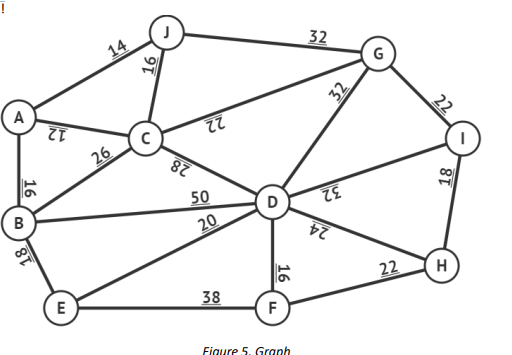

In [11]:
camino(Gr, 'J', 'F')

(['J', 'A', 'C', 'G', 'I', 'H', 'F'], 110)